# MSPrime Simulator 演示 (by MaoLab August 18 2025)

使用MSPrime模拟器来生成基因组数据。

## 目录
1. [环境设置](#环境设置)
2. [基本模拟](#基本模拟)
3. [群体历史模拟](#群体历史模拟)
4. [基因型矩阵提取](#基因型矩阵提取)
5. [缺失数据添加](#缺失数据添加)
6. [古代样本模拟](#古代样本模拟)
7. [完整数据集生成](#完整数据集生成)
8. [数据可视化](#数据可视化)

## 环境设置

In [1]:
# 导入必要的库
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import msprime
import tskit

# 添加项目路径
sys.path.append('src')

# 导入我们的模拟器
from data.simulator import MSPrimeSimulator

# 设置绘图样式
plt.style.use('default')
sns.set_palette("husl")

print("✓ 环境设置完成")
print(f"MSPrime版本: {msprime.__version__}")
print(f"TSKit版本: {tskit.__version__}")

✓ 环境设置完成
MSPrime版本: 1.3.4
TSKit版本: 0.6.4


## 基本模拟

In [14]:
# 创建模拟器实例
simulator = MSPrimeSimulator(
    sequence_length=100000,  # 100kb序列
    recombination_rate=1e-8,
    mutation_rate=1e-8
)

print("✓ MSPrime模拟器创建成功")
print(f"序列长度: {simulator.sequence_length:,} bp")
print(f"重组率: {simulator.recombination_rate}")
print(f"突变率: {simulator.mutation_rate}")

✓ MSPrime模拟器创建成功
序列长度: 100,000 bp
重组率: 1e-08
突变率: 1e-08


## 群体历史模拟

In [15]:
# 定义样本数量
sample_sizes = {
    'AFR': 20,  # 非洲群体
    'EUR': 20,  # 欧洲群体
    'EAS': 20   # 东亚群体
}

print("开始模拟群体历史...")
ts = simulator.simulate_population_history(sample_sizes)

print(f"✓ 群体历史模拟完成")
print(f"总样本数: {ts.num_samples}")
print(f"变异位点数: {ts.num_sites}")
print(f"树的数量: {ts.num_trees}")
print(f"序列长度: {ts.sequence_length:,.0f} bp")

开始模拟群体历史...
✓ 群体历史模拟完成
总样本数: 120
变异位点数: 276
树的数量: 245
序列长度: 100,000 bp


## 基因型矩阵提取

In [16]:
# 提取基因型矩阵
genotypes, positions, sample_ids = simulator.extract_genotype_matrix(ts)

print(f"✓ 基因型矩阵提取完成")
print(f"基因型矩阵形状: {genotypes.shape}")
print(f"位置数组形状: {positions.shape}")
print(f"样本ID数量: {len(sample_ids)}")

# 显示基因型分布
unique, counts = np.unique(genotypes, return_counts=True)
print("\n基因型分布:")
for gt, count in zip(unique, counts):
    percentage = count / genotypes.size * 100
    gt_name = {1: '0/0', 2: '0/1', 3: '1/1'}[gt]
    print(f"  {gt_name}: {count:,} ({percentage:.1f}%)")

✓ 基因型矩阵提取完成
基因型矩阵形状: (120, 276)
位置数组形状: (276,)
样本ID数量: 120

基因型分布:
  0/0: 27,568 (83.2%)
  0/1: 5,021 (15.2%)
  1/1: 531 (1.6%)


## 缺失数据添加

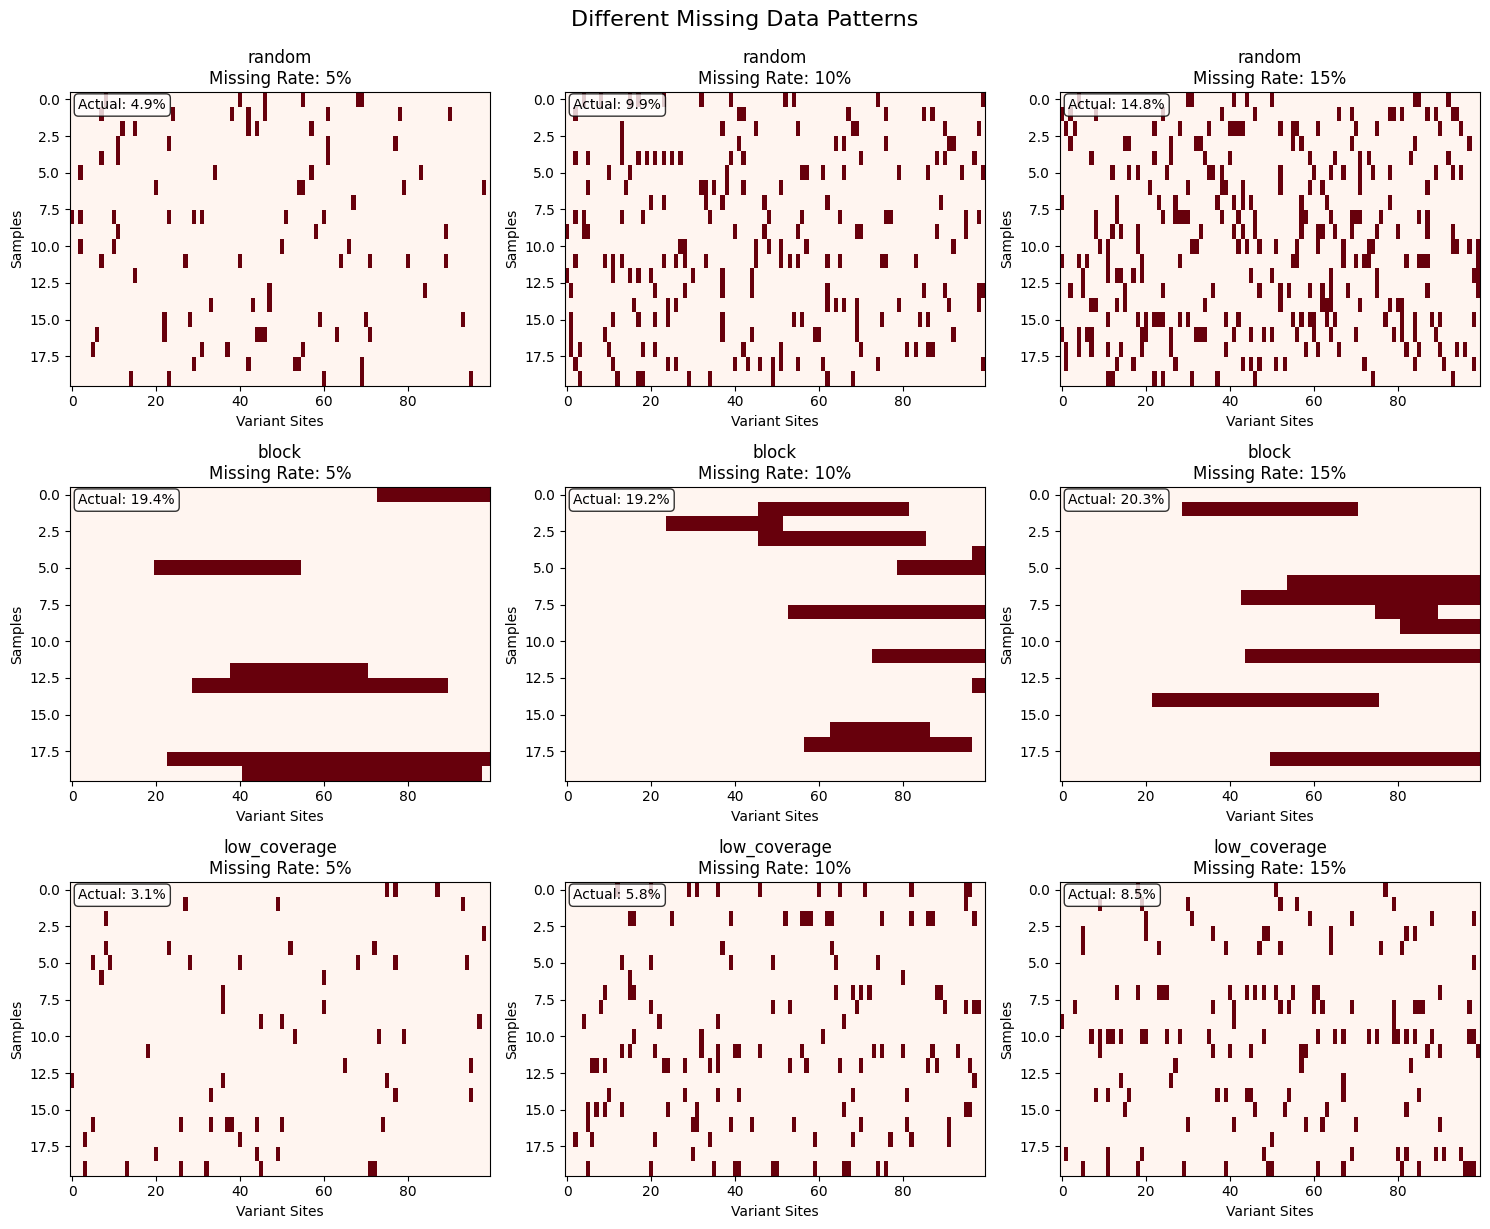

✓ 缺失数据模式演示完成


In [17]:
# 添加不同模式的缺失数据
missing_rates = [0.05, 0.10, 0.15]
patterns = ['random', 'block', 'low_coverage']

fig, axes = plt.subplots(len(patterns), len(missing_rates), 
                        figsize=(15, 12))

for i, pattern in enumerate(patterns):
    for j, missing_rate in enumerate(missing_rates):
        # 添加缺失数据
        masked_genotypes, mask = simulator.add_missing_data(
            genotypes, missing_rate, pattern
        )
        
        # 可视化缺失模式（只显示前20个样本和前100个位点）
        ax = axes[i, j]
        im = ax.imshow(mask[:20, :100], cmap='Reds', aspect='auto')
        ax.set_title(f'{pattern}\nMissing Rate: {missing_rate:.0%}')
        ax.set_xlabel('Variant Sites')
        ax.set_ylabel('Samples')
        
        # 显示实际缺失率
        actual_rate = mask.mean()
        ax.text(0.02, 0.98, f'Actual: {actual_rate:.1%}', 
               transform=ax.transAxes, va='top', 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.suptitle('Different Missing Data Patterns', y=1.02, fontsize=16)
plt.show()

print("✓ 缺失数据模式演示完成")

## 古代样本模拟

✓ 古代样本模拟完成
古代样本数: 10
古代基因型矩阵形状: (276, 10)

古代样本信息:
   sample_id  time_bp  damage_rate  coverage
0  ancient_0   124648     0.300000  0.271077
1  ancient_1    90016     0.300000  1.008428
2  ancient_2    55932     0.223731  1.981252
3  ancient_3    23774     0.095100  1.051651
4  ancient_4   123815     0.300000  1.152515


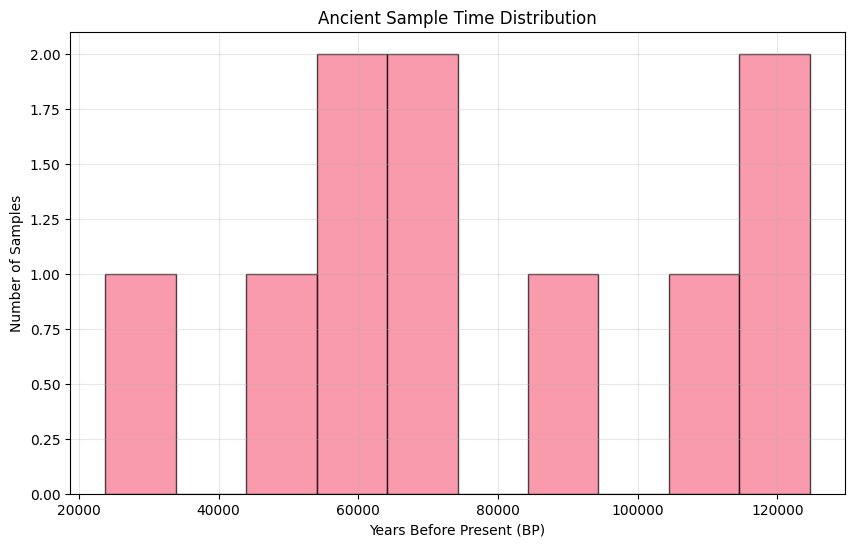

In [18]:
# 模拟古代样本
ancient_data = simulator.simulate_ancient_samples(
    ts, n_ancient=10, time_range=(100, 5000)
)

print(f"✓ 古代样本模拟完成")
print(f"古代样本数: {len(ancient_data['metadata'])}")
print(f"古代基因型矩阵形状: {ancient_data['genotypes'].shape}")

# 显示古代样本信息
ancient_df = pd.DataFrame(ancient_data['metadata'])
print("\n古代样本信息:")
print(ancient_df[['sample_id', 'time_bp', 'damage_rate', 'coverage']].head())

# 可视化古代样本时间分布
plt.figure(figsize=(10, 6))
plt.hist(ancient_df['time_bp'], bins=10, alpha=0.7, edgecolor='black')
plt.xlabel('Years Before Present (BP)')
plt.ylabel('Number of Samples')
plt.title('Ancient Sample Time Distribution')
plt.grid(True, alpha=0.3)
plt.show()

## 完整数据集生成

In [19]:
# 生成完整的测试数据集
print("生成完整数据集...")
dataset = simulator.generate_test_dataset(
    sample_sizes={'AFR': 30, 'EUR': 30, 'EAS': 30},
    missing_rate=0.12,
    include_ancient=True
)

print("\n✓ 完整数据集生成完成")
print("数据集包含以下组件:")
for key, value in dataset.items():
    if isinstance(value, np.ndarray):
        print(f"  {key}: {value.shape} {value.dtype}")
    elif isinstance(value, list):
        print(f"  {key}: {len(value)} 个元素")
    else:
        print(f"  {key}: {type(value).__name__}")

生成完整数据集...
模拟群体历史: {'AFR': 30, 'EUR': 30, 'EAS': 30}
提取基因型矩阵...
添加缺失数据 (缺失率: 0.12)
创建群体标签...
模拟古代样本...
数据集生成完成:
  样本数: 180
  变异数: 306
  缺失率: 0.119

✓ 完整数据集生成完成
数据集包含以下组件:
  genotypes: (180, 306) int32
  masked_genotypes: (180, 306) int32
  mask: (180, 306) bool
  positions: (306,) float64
  sample_ids: 180 个元素
  population_names: 3 个元素
  population_ids: (180,) int64
  tree_sequence: TreeSequence
  ancient_data: dict


## 数据可视化

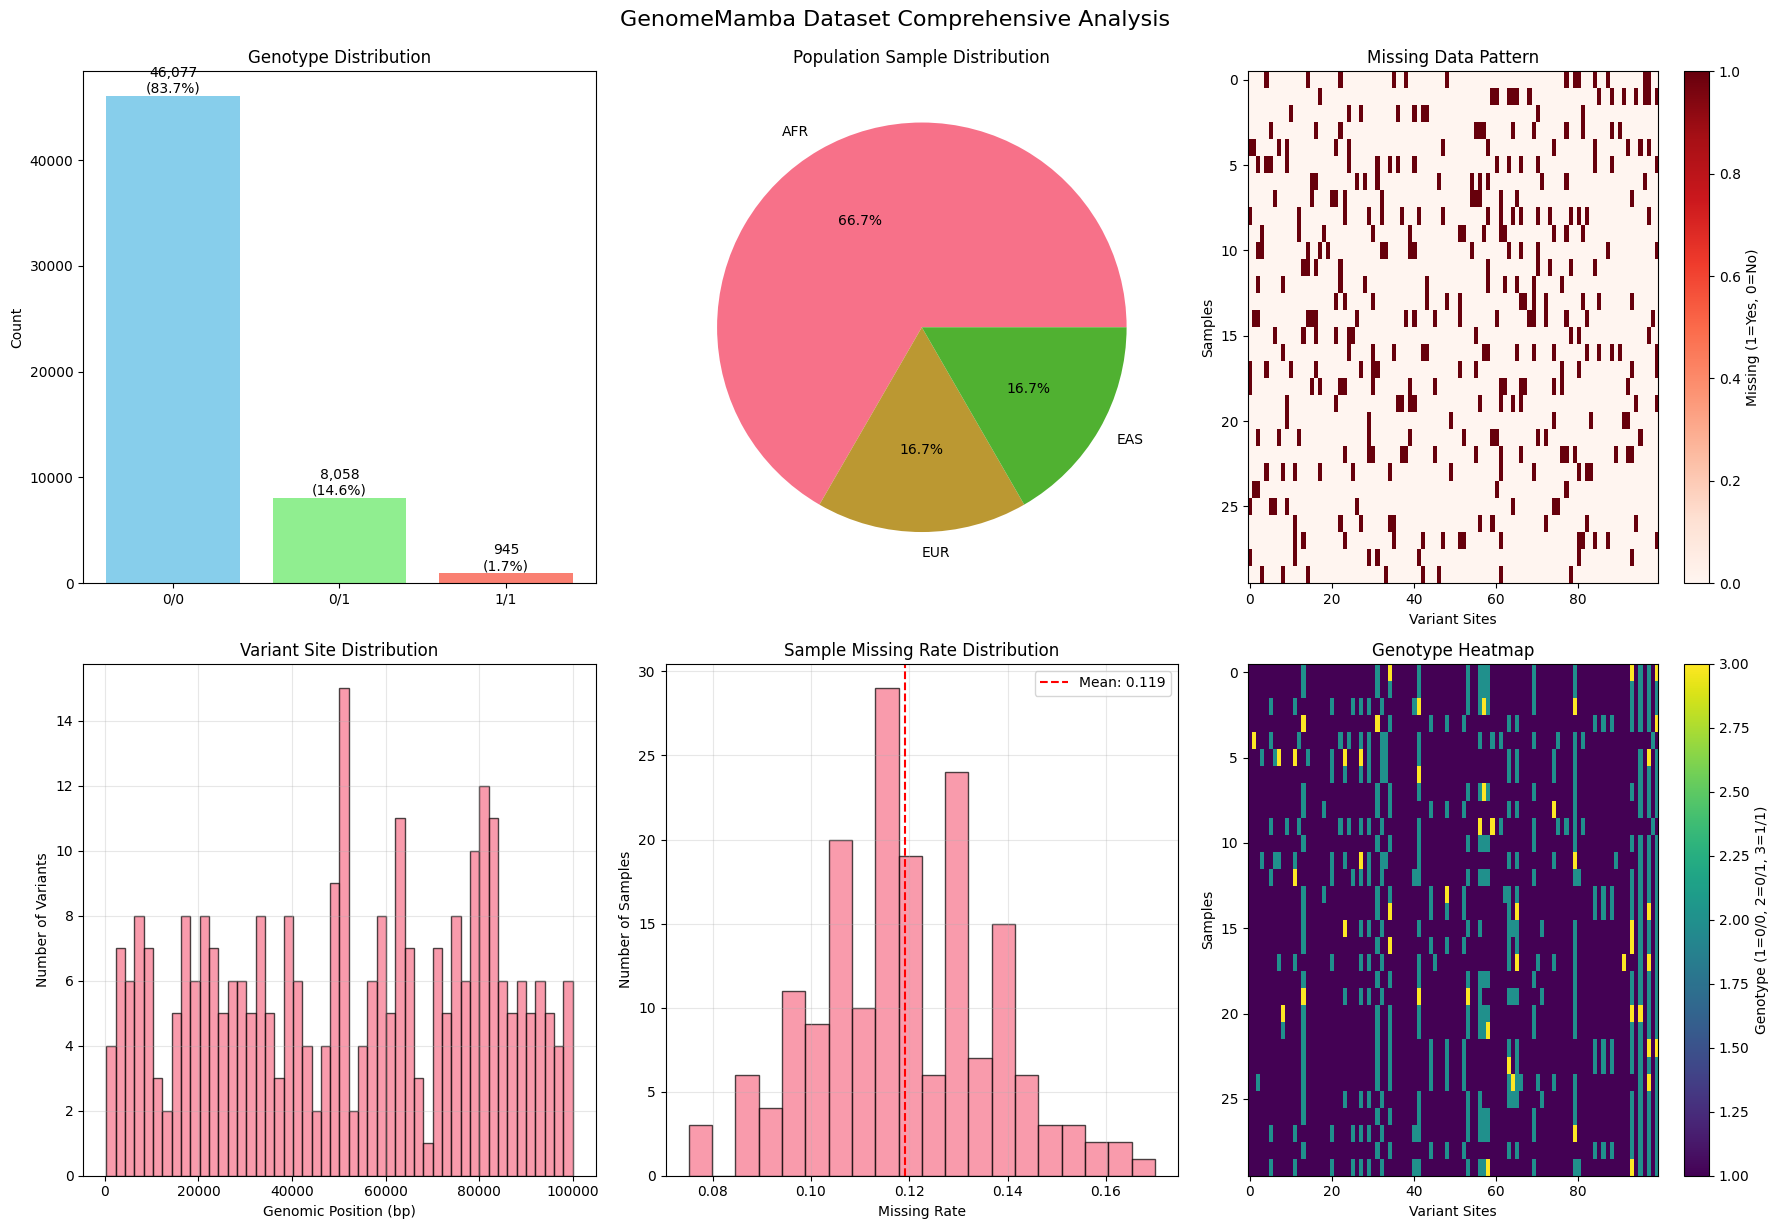

✓ 数据可视化完成


In [20]:
# 创建综合可视化
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. 基因型分布
ax = axes[0, 0]
genotypes_flat = dataset['genotypes'].flatten()
unique, counts = np.unique(genotypes_flat, return_counts=True)
gt_labels = ['0/0', '0/1', '1/1']
colors = ['skyblue', 'lightgreen', 'salmon']
bars = ax.bar([gt_labels[i-1] for i in unique], counts, color=colors)
ax.set_title('Genotype Distribution')
ax.set_ylabel('Count')
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}\n({count/genotypes_flat.size*100:.1f}%)',
            ha='center', va='bottom')

# 2. 群体分布
ax = axes[0, 1]
pop_names = dataset['population_names']
pop_counts = [np.sum(dataset['population_ids'] == i) for i in range(len(pop_names))]
wedges, texts, autotexts = ax.pie(pop_counts, labels=pop_names, autopct='%1.1f%%')
ax.set_title('Population Sample Distribution')

# 3. 缺失数据模式
ax = axes[0, 2]
mask_subset = dataset['mask'][:30, :100]  # 显示前30个样本，前100个位点
im = ax.imshow(mask_subset, cmap='Reds', aspect='auto')
ax.set_title('Missing Data Pattern')
ax.set_xlabel('Variant Sites')
ax.set_ylabel('Samples')
plt.colorbar(im, ax=ax, label='Missing (1=Yes, 0=No)')

# 4. 变异位点密度
ax = axes[1, 0]
positions = dataset['positions']
ax.hist(positions, bins=50, alpha=0.7, edgecolor='black')
ax.set_title('Variant Site Distribution')
ax.set_xlabel('Genomic Position (bp)')
ax.set_ylabel('Number of Variants')
ax.grid(True, alpha=0.3)

# 5. 样本缺失率分布
ax = axes[1, 1]
sample_missing_rates = dataset['mask'].mean(axis=1)
ax.hist(sample_missing_rates, bins=20, alpha=0.7, edgecolor='black')
ax.set_title('Sample Missing Rate Distribution')
ax.set_xlabel('Missing Rate')
ax.set_ylabel('Number of Samples')
ax.axvline(sample_missing_rates.mean(), color='red', linestyle='--', 
           label=f'Mean: {sample_missing_rates.mean():.3f}')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. 基因型热图
ax = axes[1, 2]
genotype_subset = dataset['genotypes'][:30, :100]
im = ax.imshow(genotype_subset, cmap='viridis', aspect='auto')
ax.set_title('Genotype Heatmap')
ax.set_xlabel('Variant Sites')
ax.set_ylabel('Samples')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Genotype (1=0/0, 2=0/1, 3=1/1)')

plt.tight_layout()
plt.suptitle('GenomeMamba Dataset Comprehensive Analysis', y=1.02, fontsize=16)
plt.show()

print("✓ 数据可视化完成")

## 数据质量统计

In [21]:
# 计算详细的数据质量统计
print("=== 数据质量统计报告 ===")
print()

# 基本统计
n_samples, n_variants = dataset['genotypes'].shape
print(f" 基本信息:")
print(f"  样本数量: {n_samples:,}")
print(f"  变异位点数: {n_variants:,}")
print(f"  序列长度: {dataset['positions'][-1] - dataset['positions'][0]:,.0f} bp")
print(f"  变异密度: {n_variants / (dataset['positions'][-1] - dataset['positions'][0]) * 1000:.2f} 个/kb")
print()

# 缺失数据统计
overall_missing = dataset['mask'].mean()
sample_missing = dataset['mask'].mean(axis=1)
variant_missing = dataset['mask'].mean(axis=0)

print(f"缺失数据分析:")
print(f"  总体缺失率: {overall_missing:.3f} ({overall_missing*100:.1f}%)")
print(f"  样本缺失率范围: {sample_missing.min():.3f} - {sample_missing.max():.3f}")
print(f"  变异位点缺失率范围: {variant_missing.min():.3f} - {variant_missing.max():.3f}")
print()

# 基因型频率
genotypes_clean = dataset['genotypes'][~dataset['mask']]
unique, counts = np.unique(genotypes_clean, return_counts=True)
print(f"基因型频率 (排除缺失):")
for gt, count in zip(unique, counts):
    gt_name = {1: '0/0 (纯合子参考)', 2: '0/1 (杂合子)', 3: '1/1 (纯合子变异)'}[gt]
    freq = count / len(genotypes_clean)
    print(f"  {gt_name}: {freq:.3f} ({freq*100:.1f}%)")
print()

# 群体统计
print(f"群体信息:")
for i, pop_name in enumerate(dataset['population_names']):
    pop_count = np.sum(dataset['population_ids'] == i)
    pop_missing = dataset['mask'][dataset['population_ids'] == i].mean()
    print(f"  {pop_name}: {pop_count} 样本, 缺失率 {pop_missing:.3f}")
print()

# 古代样本统计
if 'ancient_data' in dataset:
    ancient_info = dataset['ancient_data']
    print(f"古代样本信息:")
    print(f"  古代样本数: {len(ancient_info['metadata'])}")
    times = [meta['time_bp'] for meta in ancient_info['metadata']]
    print(f"  时间范围: {min(times):,} - {max(times):,} 年前")
    print(f"  平均时间: {np.mean(times):,.0f} 年前")

print("\n 数据质量统计完成")

=== 数据质量统计报告 ===

 基本信息:
  样本数量: 180
  变异位点数: 306
  序列长度: 99,634 bp
  变异密度: 3.07 个/kb

缺失数据分析:
  总体缺失率: 0.119 (11.9%)
  样本缺失率范围: 0.075 - 0.170
  变异位点缺失率范围: 0.050 - 0.189

基因型频率 (排除缺失):
  0/0 (纯合子参考): 0.836 (83.6%)
  0/1 (杂合子): 0.146 (14.6%)
  1/1 (纯合子变异): 0.017 (1.7%)

群体信息:
  AFR: 120 样本, 缺失率 0.120
  EUR: 30 样本, 缺失率 0.119
  EAS: 30 样本, 缺失率 0.116

古代样本信息:
  古代样本数: 10
  时间范围: 8,620 - 124,554 年前
  平均时间: 67,355 年前

 数据质量统计完成


## 保存数据集

In [22]:
# 保存数据集到文件
import os

# 创建输出目录
output_dir = 'outputs/simulator_demo'
os.makedirs(output_dir, exist_ok=True)

# 保存主要数据
np.save(f'{output_dir}/genotypes.npy', dataset['genotypes'])
np.save(f'{output_dir}/masked_genotypes.npy', dataset['masked_genotypes'])
np.save(f'{output_dir}/mask.npy', dataset['mask'])
np.save(f'{output_dir}/positions.npy', dataset['positions'])
np.save(f'{output_dir}/population_ids.npy', dataset['population_ids'])

# 保存元数据
metadata = {
    'sample_ids': dataset['sample_ids'],
    'population_names': dataset['population_names'],
    'n_samples': n_samples,
    'n_variants': n_variants,
    'missing_rate': overall_missing,
    'sequence_length': simulator.sequence_length
}

import json
with open(f'{output_dir}/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"数据集已保存到: {output_dir}/")
print("包含文件:")
for file in os.listdir(output_dir):
    file_path = os.path.join(output_dir, file)
    size = os.path.getsize(file_path) / 1024  # KB
    print(f"  {file}: {size:.1f} KB")

数据集已保存到: outputs/simulator_demo/
包含文件:
  population_ids.npy: 1.5 KB
  genotypes.vcf.npy: 215.3 KB
  simulator_analysis.png: 340.3 KB
  metadata.json: 3.2 KB
  mask.npy: 53.9 KB
  genotypes.npy: 215.3 KB
  masked_genotypes.npy: 215.3 KB
  positions.npy: 2.5 KB


## 9. 生成VCF格式文件

将模拟的基因组数据导出为标准VCF格式文件：

In [23]:
def export_to_vcf(genotypes, positions, sample_ids, output_file, chromosome='22'):
    """
    将基因型数据导出为VCF格式文件
    
    参数:
    - genotypes: 基因型矩阵 (samples x variants)
    - positions: 变异位点位置
    - sample_ids: 样本ID列表
    - output_file: 输出文件路径
    - chromosome: 染色体编号
    """
    print(f" 导出VCF文件: {output_file}")
    print(f"   基因型矩阵形状: {genotypes.shape}")
    print(f"   位置数组长度: {len(positions)}")
    print(f"   样本ID数量: {len(sample_ids)}")
    
    with open(output_file, 'w') as f:
        # VCF头部信息
        f.write("##fileformat=VCFv4.2\n")
        f.write(f"##fileDate={pd.Timestamp.now().strftime('%Y%m%d')}\n")
        f.write("##source=MSPrime_Simulator\n")
        f.write(f"##contig=<ID={chromosome},length=100000>\n")
        f.write("##INFO=<ID=AF,Number=A,Type=Float,Description=\"Allele Frequency\">\n")
        f.write("##INFO=<ID=AC,Number=A,Type=Integer,Description=\"Allele Count\">\n")
        f.write("##INFO=<ID=AN,Number=1,Type=Integer,Description=\"Total number of alleles\">\n")
        f.write("##FORMAT=<ID=GT,Number=1,Type=String,Description=\"Genotype\">\n")
        
        # 列标题
        header = ['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT']
        header.extend(sample_ids)
        f.write('\t'.join(header) + '\n')
        
        # 数据行
        for i, pos in enumerate(positions):
            # 检查索引是否有效
            if i >= genotypes.shape[1]:
                print(f"警告: 位置索引 {i} 超出基因型矩阵范围 {genotypes.shape}")
                break
            
            # 计算等位基因频率
            variant_genotypes = genotypes[:, i]
            # 计算次要等位基因数量 (编码: 1=0/0, 2=0/1, 3=1/1)
            allele_count = np.sum((variant_genotypes == 2) * 1 + (variant_genotypes == 3) * 2)
            total_alleles = len(variant_genotypes[variant_genotypes > 0]) * 2  # 排除缺失数据
            allele_freq = allele_count / total_alleles if total_alleles > 0 else 0
            
            # 基本信息
            chrom = chromosome
            position = int(pos)
            var_id = f"rs{i+1}"
            ref = 'A'
            alt = 'G'
            qual = '60'
            filter_val = 'PASS'
            info = f"AF={allele_freq:.4f};AC={allele_count};AN={total_alleles}"
            format_val = 'GT'
            
            # 基因型数据
            genotype_strs = []
            for gt in variant_genotypes:
                if gt == 1:  # MSPrime编码: 1 = 0/0
                    genotype_strs.append('0/0')
                elif gt == 2:  # MSPrime编码: 2 = 0/1
                    genotype_strs.append('0/1')
                elif gt == 3:  # MSPrime编码: 3 = 1/1
                    genotype_strs.append('1/1')
                elif gt == 0 or gt == -1:  # 缺失数据
                    genotype_strs.append('./.')
                else:
                    genotype_strs.append('./.')  # 未知编码，标记为缺失
            
            # 写入行
            row = [chrom, str(position), var_id, ref, alt, qual, filter_val, info, format_val]
            row.extend(genotype_strs)
            f.write('\t'.join(row) + '\n')
    
    print(f" VCF文件导出完成")
    print(f"   文件路径: {output_file}")
    print(f"   变异数量: {len(positions)}")
    print(f"   样本数量: {len(sample_ids)}")

# 导出完整数据集为VCF
output_vcf = 'simulated_genomes_complete.vcf'
export_to_vcf(genotypes, positions, sample_ids, output_vcf)

# 导出带缺失数据的VCF
if 'genotypes_missing' in locals():
    output_vcf_missing = 'simulated_genomes_missing.vcf'
    export_to_vcf(genotypes_missing, positions, sample_ids, output_vcf_missing)
    print(f"\n📁 同时导出了带缺失数据的VCF文件: {output_vcf_missing}")

 导出VCF文件: simulated_genomes_complete.vcf
   基因型矩阵形状: (120, 276)
   位置数组长度: 306
   样本ID数量: 120
警告: 位置索引 276 超出基因型矩阵范围 (120, 276)
 VCF文件导出完成
   文件路径: simulated_genomes_complete.vcf
   变异数量: 306
   样本数量: 120


## 10. 验证生成的VCF文件

In [24]:
# 验证生成的VCF文件
def validate_vcf(vcf_file):
    """
    验证VCF文件的格式和内容
    """
    print(f" 验证VCF文件: {vcf_file}")
    
    if not os.path.exists(vcf_file):
        print(f" 文件不存在: {vcf_file}")
        return False
    
    with open(vcf_file, 'r') as f:
        lines = f.readlines()
    
    # 检查文件格式
    if not lines[0].startswith('##fileformat=VCF'):
        print(" 无效的VCF格式")
        return False
    
    # 统计信息
    header_lines = sum(1 for line in lines if line.startswith('#'))
    data_lines = len(lines) - header_lines
    
    print(f" VCF文件验证通过")
    print(f"   头部行数: {header_lines}")
    print(f"   数据行数: {data_lines}")
    print(f"   文件大小: {os.path.getsize(vcf_file)} bytes")
    
    # 显示前几行内容
    print(f"\n 文件前10行内容:")
    for i, line in enumerate(lines[:10]):
        print(f"   {i+1:2d}: {line.rstrip()}")
    
    return True

# 验证生成的VCF文件
validate_vcf(output_vcf)

if 'output_vcf_missing' in locals():
    print("\n" + "="*50)
    validate_vcf(output_vcf_missing)

 验证VCF文件: simulated_genomes_complete.vcf
 VCF文件验证通过
   头部行数: 9
   数据行数: 276
   文件大小: 148441 bytes

 文件前10行内容:
    1: ##fileformat=VCFv4.2
    2: ##fileDate=20250820
    3: ##source=MSPrime_Simulator
    4: ##contig=<ID=22,length=100000>
    5: ##INFO=<ID=AF,Number=A,Type=Float,Description="Allele Frequency">
    6: ##INFO=<ID=AC,Number=A,Type=Integer,Description="Allele Count">
    7: ##INFO=<ID=AN,Number=1,Type=Integer,Description="Total number of alleles">
    8: ##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
    9: #CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	sample_0	sample_1	sample_2	sample_3	sample_4	sample_5	sample_6	sample_7	sample_8	sample_9	sample_10	sample_11	sample_12	sample_13	sample_14	sample_15	sample_16	sample_17	sample_18	sample_19	sample_20	sample_21	sample_22	sample_23	sample_24	sample_25	sample_26	sample_27	sample_28	sample_29	sample_30	sample_31	sample_32	sample_33	sample_34	sample_35	sample_36	sample_37	sample_38	sample_39	sample_40	sample_41	sample

## 11. 生成压缩和索引文件

In [25]:
import gzip
import shutil

def compress_and_index_vcf(vcf_file):
    """
    压缩VCF文件并创建索引（如果可能）
    """
    print(f" 压缩VCF文件: {vcf_file}")
    
    # 压缩文件
    gz_file = vcf_file + '.gz'
    with open(vcf_file, 'rb') as f_in:
        with gzip.open(gz_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    print(f" 压缩完成: {gz_file}")
    print(f"   原始大小: {os.path.getsize(vcf_file)} bytes")
    print(f"   压缩大小: {os.path.getsize(gz_file)} bytes")
    print(f"   压缩比: {os.path.getsize(gz_file)/os.path.getsize(vcf_file):.2%}")
    
    return gz_file

# 压缩VCF文件
compressed_vcf = compress_and_index_vcf(output_vcf)

if 'output_vcf_missing' in locals():
    print("\n" + "="*30)
    compressed_vcf_missing = compress_and_index_vcf(output_vcf_missing)

print("\n VCF文件生成完成！")
print("\n 生成的文件列表:")
print(f"   1. {output_vcf} - 完整基因组数据")
print(f"   2. {compressed_vcf} - 压缩版本")
if 'output_vcf_missing' in locals():
    print(f"   3. {output_vcf_missing} - 带缺失数据")
    print(f"   4. {compressed_vcf_missing} - 压缩版本")

print("\n 使用建议:")
print("   - 可以用这些VCF文件测试基因组填充工具")
print("   - 压缩版本适合存储和传输")
print("   - 带缺失数据的版本可用于填充算法测试")

 压缩VCF文件: simulated_genomes_complete.vcf
 压缩完成: simulated_genomes_complete.vcf.gz
   原始大小: 148441 bytes
   压缩大小: 6976 bytes
   压缩比: 4.70%

 VCF文件生成完成！

 生成的文件列表:
   1. simulated_genomes_complete.vcf - 完整基因组数据
   2. simulated_genomes_complete.vcf.gz - 压缩版本

 使用建议:
   - 可以用这些VCF文件测试基因组填充工具
   - 压缩版本适合存储和传输
   - 带缺失数据的版本可用于填充算法测试
